<a href="https://colab.research.google.com/github/ilyaleonovStudy/test/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Untitled0_v2_ipynb123%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ЛР №1. Разведочный и регрессионный анализ данных на основе нейросетевых моделей  
## Вариант 3: прибыль стартапов (Profit)

**Что делаем по заданию:**
- EDA (описательная статистика, визуализация, корреляции, очистка)
- 4 набора данных: исходный / нормализованный исходный / сформированный / нормализованный сформированный
- 2 модели: **Dense** и **LSTM**
- Метрики: **RMSE** и **R²** (train/val/test)
- Grid Search гиперпараметров **для LSTM**

### Источник данных
Используется открытый учебный датасет **50 Startups**. В работе он подключается **из локального файла** `50_Startups.csv`.
> В Google Colab файл можно заранее загрузить в среду (панель *Files* слева) или через `files.upload()`.


## 1) Импорт библиотек

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 2) Загрузка данных из локального файла `50_Startups.csv`
Если файла нет в окружении — загрузим вручную.

In [ ]:

import os
import pandas as pd

DATA_FILE = "50_Startups.csv"

if os.path.exists(DATA_FILE):
    df = pd.read_csv(DATA_FILE)
    print(f"Loaded local file: {DATA_FILE}")
else:
    print("Файл 50_Startups.csv не найден в текущей директории.")
    print("Если вы в Google Colab, загрузите файл вручную через окно выбора.")
    try:
        from google.colab import files
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        df = pd.read_csv(filename)
        print(f"Loaded uploaded file: {filename}")
    except Exception as e:
        raise RuntimeError(
            "Не удалось загрузить файл. Положите 50_Startups.csv рядом с ноутбуком "
            "или загрузите через Colab files.upload()."
        ) from e

df.head()


Файл 50_Startups.csv не найден в текущей директории.
Если вы в Google Colab, загрузите файл вручную через окно выбора.


Saving 50_Startups.csv to 50_Startups.csv
Loaded uploaded file: 50_Startups.csv


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## 3) EDA — разведочный анализ данных
### 3a) Общая информация и описательная статистика

In [ ]:

print("Размерность:", df.shape)
display(df.info())
display(df.describe(include="all").T)


Размерность: (50, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
R&D Spend,50.0,NaN,NaN,NaN,73721.6156,45902.256482,0.0,39936.37,73051.08,101602.8,165349.2
Administration,50.0,NaN,NaN,NaN,121344.6396,28017.802755,51283.14,103730.875,122699.795,144842.18,182645.56
Marketing Spend,50.0,NaN,NaN,NaN,211025.0978,122290.310726,0.0,129300.1325,212716.24,299469.085,471784.1
State,50,3,New York,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profit,50.0,NaN,NaN,NaN,112012.6392,40306.180338,14681.4,90138.9025,107978.19,139765.9775,192261.83


### 3b) Визуализация (1D/2D) и корреляции

Числовые: ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']
Категориальные: ['State']


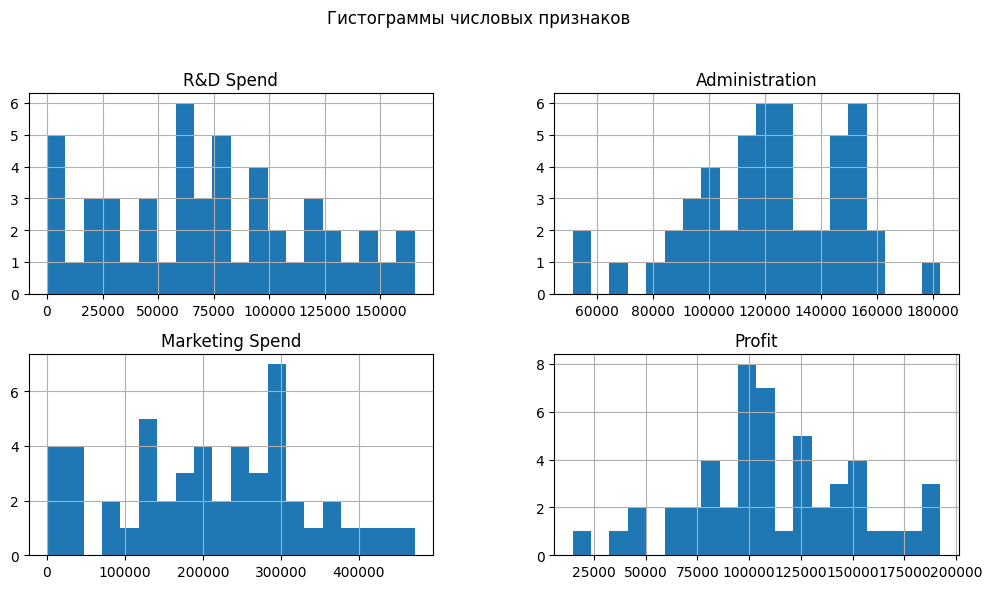

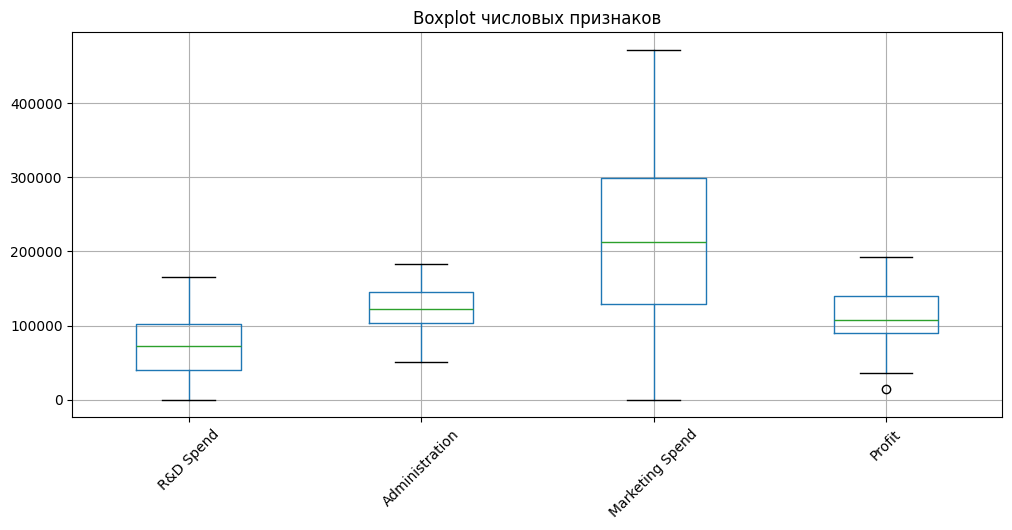

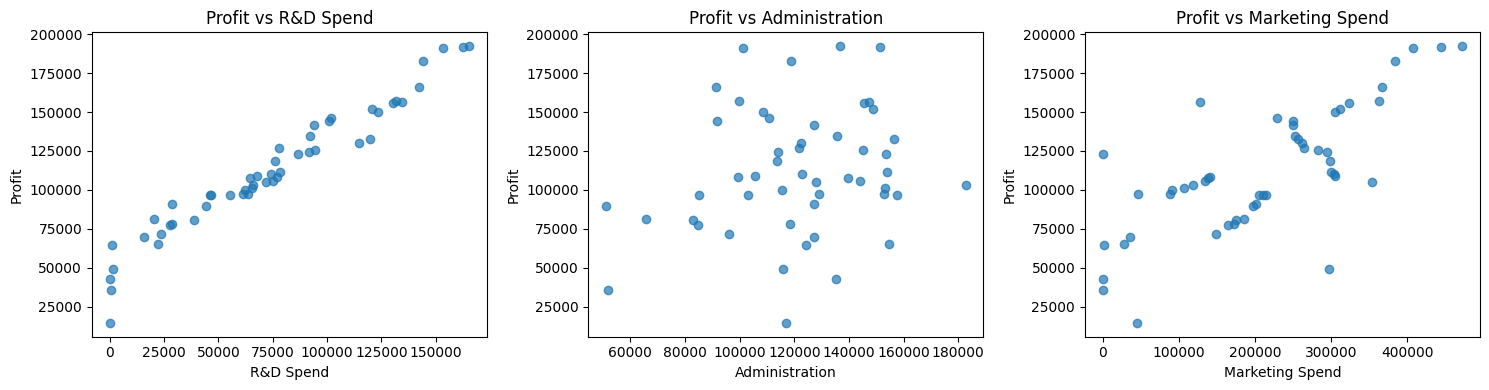

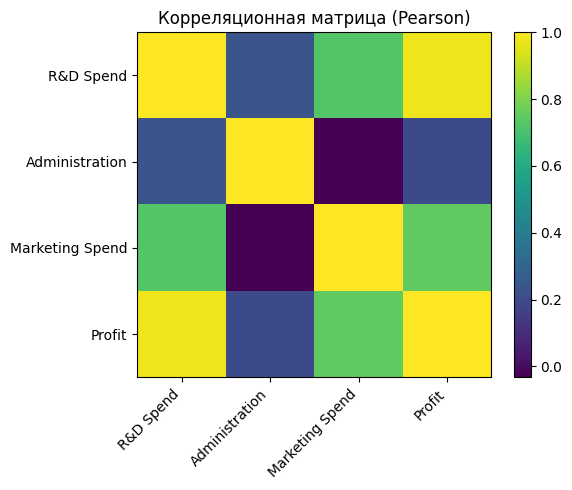

In [ ]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Числовые:", num_cols)
print("Категориальные:", cat_cols)

# Гистограммы
df[num_cols].hist(bins=20, figsize=(12, 6))
plt.suptitle("Гистограммы числовых признаков", y=1.02)
plt.show()

# Boxplot
plt.figure(figsize=(12, 5))
df[num_cols].boxplot()
plt.title("Boxplot числовых признаков")
plt.xticks(rotation=45)
plt.show()

# Scatter: Profit vs расходы
target = "Profit"
feat_numeric = [c for c in num_cols if c != target]
fig, axes = plt.subplots(1, len(feat_numeric), figsize=(5*len(feat_numeric), 4))
if len(feat_numeric) == 1:
    axes = [axes]
for ax, c in zip(axes, feat_numeric):
    ax.scatter(df[c], df[target], alpha=0.7)
    ax.set_xlabel(c)
    ax.set_ylabel(target)
    ax.set_title(f"{target} vs {c}")
plt.tight_layout()
plt.show()

# Корреляционная матрица
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(6, 5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title("Корреляционная матрица (Pearson)")
plt.tight_layout()
plt.show()


### 3c) Проверка пропусков и дубликатов

In [ ]:

print("Пропуски по столбцам:")
display(df.isna().sum())

dup = df.duplicated().sum()
print("Дубликаты строк:", dup)


Пропуски по столбцам:


,0
R&D Spend,0
Administration,0
Marketing Spend,0
State,0
Profit,0


Дубликаты строк: 0


### 3d) Корреляция признаков с Profit

In [ ]:

target = "Profit"
corr_to_target = df[df.select_dtypes(include=[np.number]).columns].corr(numeric_only=True)[target].sort_values(ascending=False)
display(corr_to_target)


,Profit
Profit,1.000000
R&D Spend,0.972900
Marketing Spend,0.747766
Administration,0.200717


### 3e) Feature Engineering (формирование признаков)
- TotalSpend = сумма расходов
- доли расходов
- логарифмы расходов

In [ ]:

df_fe = df.copy()

df_fe["TotalSpend"] = df_fe["R&D Spend"] + df_fe["Administration"] + df_fe["Marketing Spend"]
eps = 1e-9
df_fe["RD_share"] = df_fe["R&D Spend"] / (df_fe["TotalSpend"] + eps)
df_fe["Admin_share"] = df_fe["Administration"] / (df_fe["TotalSpend"] + eps)
df_fe["Mkt_share"] = df_fe["Marketing Spend"] / (df_fe["TotalSpend"] + eps)

df_fe["log_RD"] = np.log1p(df_fe["R&D Spend"])
df_fe["log_Admin"] = np.log1p(df_fe["Administration"])
df_fe["log_Mkt"] = np.log1p(df_fe["Marketing Spend"])

df_fe.head()


,R&D Spend,Administration,Marketing Spend,State,Profit,TotalSpend,RD_share,Admin_share,Mkt_share,log_RD,log_Admin,log_Mkt
0,165349.20,136897.80,471784.10,New York,192261.83,774031.10,0.213621,0.176863,0.609516,12.015821,11.826997,13.064279
1,162597.70,151377.59,443898.53,California,191792.06,757873.82,0.214545,0.199740,0.585716,11.999040,11.927539,13.003354
2,153441.51,101145.55,407934.54,Florida,191050.39,662521.60,0.231602,0.152668,0.615730,11.941081,11.524326,12.918864
3,144372.41,118671.85,383199.62,New York,182901.99,646243.88,0.223402,0.183633,0.592964,11.880158,11.684126,12.856314
4,142107.34,91391.77,366168.42,Florida,166187.94,599667.53,0.236977,0.152404,0.610619,11.864345,11.422922,12.810851


### 3f) Отбор существенных признаков
Оставим числовые признаки, у которых |corr(Profit)| >= порога. `State` оставляем и кодируем OHE.

In [ ]:

target = "Profit"

num_cols_fe = df_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_fe = df_fe.select_dtypes(exclude=[np.number]).columns.tolist()

corr_fe = df_fe[num_cols_fe].corr(numeric_only=True)[target].drop(target).abs().sort_values(ascending=False)
display(corr_fe)

THRESH = 0.2
selected_num = corr_fe[corr_fe >= THRESH].index.tolist()
selected_cat = cat_cols_fe  # обычно ['State']

print("Отобранные числовые признаки:", selected_num)
print("Категориальные признаки:", selected_cat)

df_sel = df_fe[selected_num + selected_cat + [target]].copy()
df_sel.head()


,Profit
R&D Spend,0.972900
TotalSpend,0.872598
RD_share,0.772206
Marketing Spend,0.747766
log_RD,0.718622
Admin_share,0.673626
log_Mkt,0.435558
Mkt_share,0.434495
log_Admin,0.232470
Administration,0.200717


Отобранные числовые признаки: ['R&D Spend', 'TotalSpend', 'RD_share', 'Marketing Spend', 'log_RD', 'Admin_share', 'log_Mkt', 'Mkt_share', 'log_Admin', 'Administration']
Категориальные признаки: ['State']


,R&D Spend,TotalSpend,RD_share,Marketing Spend,log_RD,Admin_share,log_Mkt,Mkt_share,log_Admin,Administration,State,Profit
0,165349.20,774031.10,0.213621,471784.10,12.015821,0.176863,13.064279,0.609516,11.826997,136897.80,New York,192261.83
1,162597.70,757873.82,0.214545,443898.53,11.999040,0.199740,13.003354,0.585716,11.927539,151377.59,California,191792.06
2,153441.51,662521.60,0.231602,407934.54,11.941081,0.152668,12.918864,0.615730,11.524326,101145.55,Florida,191050.39
3,144372.41,646243.88,0.223402,383199.62,11.880158,0.183633,12.856314,0.592964,11.684126,118671.85,New York,182901.99
4,142107.34,599667.53,0.236977,366168.42,11.864345,0.152404,12.810851,0.610619,11.422922,91391.77,Florida,166187.94


## 4) Подготовка 4 наборов данных и разбиение train/val/test
Нормализация по варианту: используем `sklearn.preprocessing.Normalizer` для числовых признаков.


In [ ]:

def make_splits(X, y, test_size=0.2, val_size=0.2, seed=SEED):
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_ratio, random_state=seed
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def build_preprocessor(num_features, cat_features, normalize=False):
    transformers = []
    num_pipe = Pipeline([("norm", Normalizer())]) if normalize else "passthrough"
    transformers.append(("num", num_pipe, num_features))

    if len(cat_features) > 0:
        cat_pipe = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"))])
        transformers.append(("cat", cat_pipe, cat_features))

    return ColumnTransformer(transformers)

def prepare_dataset(df_work, target_col="Profit", normalize=False):
    num_features = [c for c in df_work.columns if c != target_col and df_work[c].dtype != "object"]
    cat_features = [c for c in df_work.columns if df_work[c].dtype == "object"]

    X_raw = df_work.drop(columns=[target_col])
    y = df_work[target_col].values.astype("float32")

    pre = build_preprocessor(num_features, cat_features, normalize=normalize)
    X = pre.fit_transform(X_raw)

    if hasattr(X, "toarray"):
        X = X.toarray()
    X = X.astype("float32")
    return X, y

# 4 набора данных
X0, y0 = prepare_dataset(df,     normalize=False)  # исходный
X1, y1 = prepare_dataset(df,     normalize=True)   # нормализованный исходный
X2, y2 = prepare_dataset(df_sel, normalize=False)  # сформированный
X3, y3 = prepare_dataset(df_sel, normalize=True)   # нормализованный сформированный

datasets = {
    "orig": (X0, y0),
    "orig_norm": (X1, y1),
    "sel": (X2, y2),
    "sel_norm": (X3, y3),
}

for name, (X, y) in datasets.items():
    print(name, "X:", X.shape, "y:", y.shape)


orig X: (50, 6) y: (50,)
orig_norm X: (50, 6) y: (50,)
sel X: (50, 13) y: (50,)
sel_norm X: (50, 13) y: (50,)


## 5) Сравнение моделей Dense vs LSTM (RMSE и R² на train/val)
LSTM применяем к табличным данным, интерпретируя вектор признаков как последовательность длины `n_features`.

In [ ]:

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_metrics(y_true, y_pred):
    return {"RMSE": rmse(y_true, y_pred), "R2": float(r2_score(y_true, y_pred))}

def build_dense_model(input_dim, hidden=(64, 32), lr=1e-3, dropout=0.1):
    model = keras.Sequential([layers.Input(shape=(input_dim,))])
    for h in hidden:
        model.add(layers.Dense(h, activation="relu"))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

def build_lstm_model(n_features, lstm_units=32, dense_units=16, lr=1e-3, dropout=0.1):
    inp = layers.Input(shape=(n_features, 1))
    x = layers.LSTM(lstm_units)(inp)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

def train(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=16, verbose=0):
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    return model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[es]
    )

results = []
histories = {}

for ds_name, (X, y) in datasets.items():
    X_train, X_val, X_test, y_train, y_val, y_test = make_splits(X, y)
    n_feat = X.shape[1]

    # Dense
    dense = build_dense_model(input_dim=n_feat)
    h_dense = train(dense, X_train, y_train, X_val, y_val)
    pred_tr = dense.predict(X_train, verbose=0).ravel()
    pred_va = dense.predict(X_val, verbose=0).ravel()
    tr = eval_metrics(y_train, pred_tr)
    va = eval_metrics(y_val, pred_va)
    results.append({"dataset": ds_name, "model": "Dense",
                    "train_RMSE": tr["RMSE"], "train_R2": tr["R2"],
                    "val_RMSE": va["RMSE"], "val_R2": va["R2"]})
    histories[(ds_name, "Dense")] = h_dense

    # LSTM
    X_train_seq = X_train.reshape(-1, n_feat, 1)
    X_val_seq = X_val.reshape(-1, n_feat, 1)

    lstm = build_lstm_model(n_features=n_feat)
    h_lstm = train(lstm, X_train_seq, y_train, X_val_seq, y_val)
    pred_tr = lstm.predict(X_train_seq, verbose=0).ravel()
    pred_va = lstm.predict(X_val_seq, verbose=0).ravel()
    tr = eval_metrics(y_train, pred_tr)
    va = eval_metrics(y_val, pred_va)
    results.append({"dataset": ds_name, "model": "LSTM",
                    "train_RMSE": tr["RMSE"], "train_R2": tr["R2"],
                    "val_RMSE": va["RMSE"], "val_R2": va["R2"]})
    histories[(ds_name, "LSTM")] = h_lstm

res_df = pd.DataFrame(results).sort_values(["val_RMSE", "val_R2"], ascending=[True, False])
display(res_df)

best_row = res_df.iloc[0].to_dict()
best_dataset = best_row["dataset"]
best_model = best_row["model"]
print("Лучшая модель по валидации:", best_model, "| лучший набор:", best_dataset)


,dataset,model,train_RMSE,train_R2,val_RMSE,val_R2
4,sel,Dense,21615.851221,0.712649,12476.705976,0.922437
0,orig,Dense,30774.950853,0.417545,12485.716639,0.922325
6,sel_norm,Dense,117654.635472,-7.513057,120219.183295,-6.201142
2,orig_norm,Dense,119894.857404,-7.840331,122426.504843,-6.468007
7,sel_norm,LSTM,121847.844265,-8.130680,124303.500578,-6.698756
1,orig,LSTM,121908.047708,-8.139706,124363.025759,-6.706131
3,orig_norm,LSTM,121985.011538,-8.151250,124439.096622,-6.715561
5,sel,LSTM,122013.927074,-8.155588,124467.668284,-6.719105


Лучшая модель по валидации: Dense | лучший набор: sel


### График обучения лучшей модели

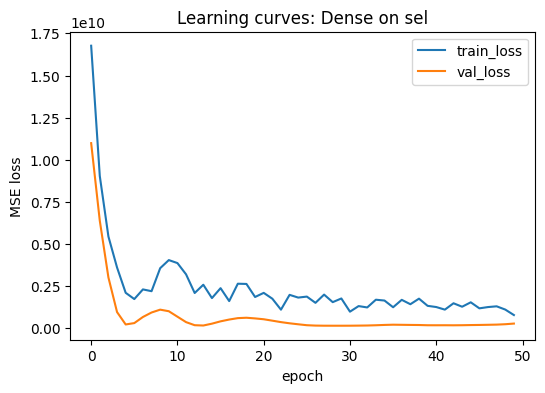

In [ ]:

best_hist = histories[(best_dataset, best_model)]
plt.figure(figsize=(6,4))
plt.plot(best_hist.history["loss"], label="train_loss")
plt.plot(best_hist.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title(f"Learning curves: {best_model} on {best_dataset}")
plt.legend()
plt.show()


## 6) Оценка лучшей модели на тестовой выборке

In [ ]:

X, y = datasets[best_dataset]
X_train, X_val, X_test, y_train, y_val, y_test = make_splits(X, y)
n_feat = X.shape[1]

if best_model == "Dense":
    model = build_dense_model(input_dim=n_feat)
    train(model, X_train, y_train, X_val, y_val)
    y_pred_test = model.predict(X_test, verbose=0).ravel()
else:
    X_train_seq = X_train.reshape(-1, n_feat, 1)
    X_val_seq   = X_val.reshape(-1, n_feat, 1)
    X_test_seq  = X_test.reshape(-1, n_feat, 1)
    model = build_lstm_model(n_features=n_feat)
    train(model, X_train_seq, y_train, X_val_seq, y_val)
    y_pred_test = model.predict(X_test_seq, verbose=0).ravel()

test_metrics = eval_metrics(y_test, y_pred_test)
print("Test metrics:", test_metrics)


Test metrics: {'RMSE': 23598.13416353081, 'R2': 0.31232720613479614}


## 7) Grid Search гиперпараметров для LSTM на лучшем наборе данных

In [ ]:

X, y = datasets[best_dataset]
X_train, X_val, X_test, y_train, y_val, y_test = make_splits(X, y)
n_feat = X.shape[1]

X_train_seq = X_train.reshape(-1, n_feat, 1)
X_val_seq   = X_val.reshape(-1, n_feat, 1)
X_test_seq  = X_test.reshape(-1, n_feat, 1)

grid = {
    "lstm_units": [16, 32, 64],
    "dense_units": [8, 16, 32],
    "lr": [1e-2, 1e-3],
    "dropout": [0.0, 0.1],
    "batch_size": [8, 16],
}

def grid_search_lstm(X_tr, y_tr, X_va, y_va, n_feat, grid, epochs=250):
    rows = []
    best = None
    best_params = None

    for lstm_units in grid["lstm_units"]:
        for dense_units in grid["dense_units"]:
            for lr in grid["lr"]:
                for dropout in grid["dropout"]:
                    for batch_size in grid["batch_size"]:
                        model = build_lstm_model(
                            n_features=n_feat,
                            lstm_units=lstm_units,
                            dense_units=dense_units,
                            lr=lr,
                            dropout=dropout
                        )
                        train(model, X_tr, y_tr, X_va, y_va, epochs=epochs, batch_size=batch_size, verbose=0)
                        pred_va = model.predict(X_va, verbose=0).ravel()
                        m_va = eval_metrics(y_va, pred_va)

                        row = {
                            "lstm_units": lstm_units,
                            "dense_units": dense_units,
                            "lr": lr,
                            "dropout": dropout,
                            "batch_size": batch_size,
                            "val_RMSE": m_va["RMSE"],
                            "val_R2": m_va["R2"],
                        }
                        rows.append(row)

                        score = (m_va["RMSE"], -m_va["R2"])
                        if best is None or score < best:
                            best = score
                            best_params = row

    return pd.DataFrame(rows).sort_values(["val_RMSE", "val_R2"], ascending=[True, False]), best_params

grid_df, best_params = grid_search_lstm(X_train_seq, y_train, X_val_seq, y_val, n_feat, grid, epochs=250)
display(grid_df.head(10))
print("Лучшие гиперпараметры:", best_params)


,lstm_units,dense_units,lr,dropout,batch_size,val_RMSE,val_R2
66,64,32,0.01,0.1,8,45768.462155,-0.043726
64,64,32,0.01,0.0,8,48166.115226,-0.155945
40,32,32,0.01,0.0,8,50827.643502,-0.287223
42,32,32,0.01,0.1,8,56471.534776,-0.588960
58,64,16,0.01,0.1,8,59067.798334,-0.738423
56,64,16,0.01,0.0,8,61345.105885,-0.875054
18,16,32,0.01,0.1,8,63180.681604,-0.988943
67,64,32,0.01,0.1,16,67212.204606,-1.250868
65,64,32,0.01,0.0,16,70943.732972,-1.507736
16,16,32,0.01,0.0,8,81656.190849,-2.322248


Лучшие гиперпараметры: {'lstm_units': 64, 'dense_units': 32, 'lr': 0.01, 'dropout': 0.1, 'batch_size': 8, 'val_RMSE': 45768.4621546322, 'val_R2': -0.04372584819793701}


## 8) Тестовая оценка LSTM: baseline vs tuned

In [ ]:

# Baseline LSTM
baseline_lstm = build_lstm_model(n_features=n_feat, lstm_units=32, dense_units=16, lr=1e-3, dropout=0.1)
train(baseline_lstm, X_train_seq, y_train, X_val_seq, y_val, epochs=300, batch_size=16, verbose=0)
pred_test_base = baseline_lstm.predict(X_test_seq, verbose=0).ravel()
base_test = eval_metrics(y_test, pred_test_base)

# Tuned LSTM
tuned_lstm = build_lstm_model(
    n_features=n_feat,
    lstm_units=int(best_params["lstm_units"]),
    dense_units=int(best_params["dense_units"]),
    lr=float(best_params["lr"]),
    dropout=float(best_params["dropout"]),
)
train(tuned_lstm, X_train_seq, y_train, X_val_seq, y_val,
      epochs=300, batch_size=int(best_params["batch_size"]), verbose=0)
pred_test_tuned = tuned_lstm.predict(X_test_seq, verbose=0).ravel()
tuned_test = eval_metrics(y_test, pred_test_tuned)

print("Baseline LSTM test:", base_test)
print("Tuned LSTM test   :", tuned_test)

pd.DataFrame([
    {"model":"LSTM baseline", "test_RMSE": base_test["RMSE"], "test_R2": base_test["R2"]},
    {"model":"LSTM tuned",    "test_RMSE": tuned_test["RMSE"], "test_R2": tuned_test["R2"]},
])


Baseline LSTM test: {'RMSE': 101355.32617479951, 'R2': -11.685853004455566}
Tuned LSTM test   : {'RMSE': 32862.67183294748, 'R2': -0.333620548248291}


,model,test_RMSE,test_R2
0,LSTM baseline,101355.326175,-11.685853
1,LSTM tuned,32862.671833,-0.333621


## 9) Выводы
- Данные загружаются из локального файла `50_Startups.csv`.
- Проведён EDA, инженерия признаков и отбор.
- Подготовлены 4 набора данных, включая нормализацию (по варианту).
- Сравнены Dense и LSTM на одинаковых разбиениях.
- Выполнен Grid Search гиперпараметров для LSTM и сравнение на тесте.
